## Convert .exe files to images

In [ ]:
import os
import numpy as np
from PIL import Image

def exe_to_image(exe_path, image_size=(128, 128)):
    """
    Convert a .exe file to a grayscale image by visualizing its binary content.
    
    Args:
    - exe_path (str): Path to the .exe file.
    - image_size (tuple): Desired size of the output image (height, width).
    
    Returns:
    - image (PIL Image): Grayscale image representation of the executable.
    """
    # Read the executable file as binary
    with open(exe_path, 'rb') as file:
        binary_data = file.read()
    
    # Convert binary data to a numpy array of bytes
    byte_array = np.frombuffer(binary_data, dtype=np.uint8)

    # Calculate the required image size (height x width) for the given image_size
    num_pixels = image_size[0] * image_size[1]

    # If the binary data is larger than required, crop it
    if byte_array.size > num_pixels:
        byte_array = byte_array[:num_pixels]
    # If the binary data is smaller, pad it with zeros
    elif byte_array.size < num_pixels:
        byte_array = np.pad(byte_array, (0, num_pixels - byte_array.size), mode='constant', constant_values=0)

    # Reshape the byte array into the desired image shape
    image_array = byte_array.reshape(image_size)

    # Convert numpy array to a PIL image (grayscale)
    image = Image.fromarray(image_array.astype(np.uint8), mode='L')

    return image

def save_exe_as_image(exe_path, output_path, image_size=(128, 128)):
    """
    Save an executable file as an image.
    
    Args:
    - exe_path (str): Path to the .exe file.
    - output_path (str): Path where the image will be saved.
    - image_size (tuple): Desired image size (height, width).
    """
    # Convert executable to image
    image = exe_to_image(exe_path, image_size)
    
    # Save the image
    image.save(output_path)
    print(f"Image saved at {output_path}")

# Example usage
exe_file_path = "path/to/your/software.exe"
output_image_path = "path/to/output/image.png"

save_exe_as_image(exe_file_path, output_image_path, image_size=(128, 128))


## Loading Data and Visualizing the data

In [36]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [37]:
def visualize_sample_images(data_loader, class_names, num_images=9):
    """
    Visualize a grid of sample images with their corresponding labels.

    Args:
    - data_loader (DataLoader): PyTorch DataLoader object.
    - class_names (list): List of class labels.
    - num_images (int): Number of images to display (default: 9).
    """
    
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    
    grid_size = int(np.ceil(np.sqrt(num_images)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_images):
        if i < len(images):
            img = images[i].numpy().transpose((1, 2, 0))  
            img = (img * 0.5) + 0.5  
            label = class_names[labels[i]]

            # Plot image
            axes[i].imshow(img.squeeze(), cmap="gray")
            axes[i].set_title(label)
            axes[i].axis("off")
        else:
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

Classes: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


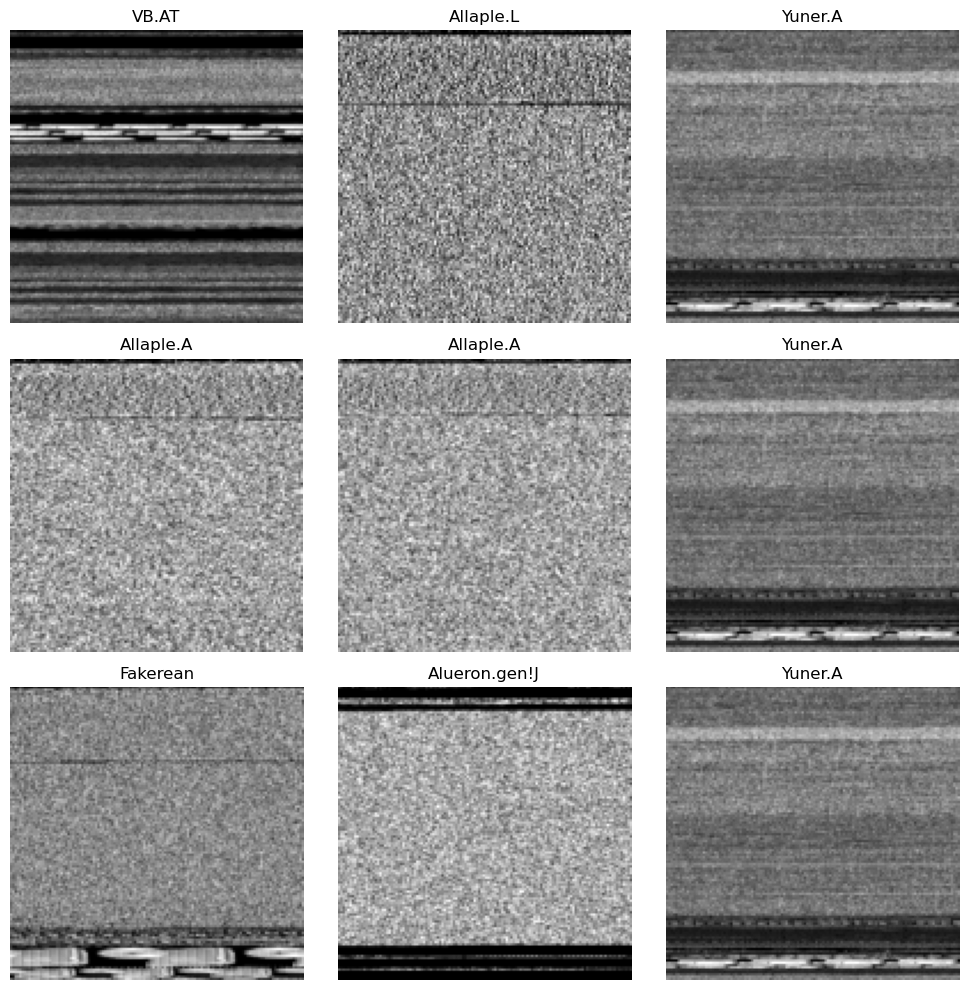

In [38]:

# Define transformations for the images
transform = transforms.Compose([
    transforms.Grayscale(),       
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),        
    transforms.Normalize((0.5,), (0.5,))  
])


data_dir = r"C:\csulb_projects\anomaly_detection\myfiles\data\malimg_paper_dataset_imgs"

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class_names = dataset.classes
print(f"Classes: {class_names}")

#visualizing the dataset
visualize_sample_images(train_loader, class_names)

In [39]:
import os
import matplotlib.pyplot as plt

def count_images_in_subfolders(data_dir):
    """
    Count the number of images in each subfolder of the given directory.

    Args:
    - data_dir (str): Path to the main dataset directory.

    Returns:
    - counts (dict): Dictionary with subfolder names as keys and image counts as values.
    """
    counts = {}
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):  # Ensure it's a directory
            counts[subfolder] = len(os.listdir(subfolder_path))
    return counts

def plot_image_counts(image_counts):
    """
    Plot the counts of images in each subfolder.

    Args:
    - image_counts (dict): Dictionary with subfolder names as keys and image counts as values.
    """
    subfolders = list(image_counts.keys())
    counts = list(image_counts.values())

    plt.figure(figsize=(10, 6))
    plt.barh(subfolders, counts, color='skyblue')
    plt.xlabel('Number of Images')
    plt.ylabel('Subfolder Names')
    plt.title('Image Count in Each Subfolder')
    plt.tight_layout()
    plt.show()

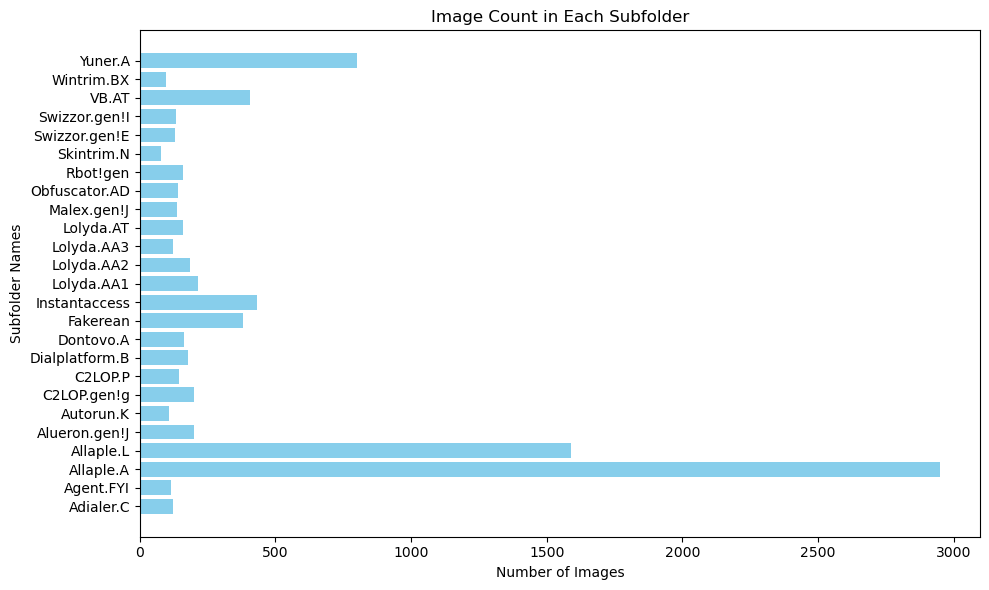

In [40]:
# Get image counts and plot
image_counts = count_images_in_subfolders(data_dir)
plot_image_counts(image_counts)

## Model Structure

In [41]:
#Malware Model
class MalwareCNN(nn.Module):
    def __init__(self, num_classes):
        super(MalwareCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Intializing Opitmizer and loss functions

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_names)
model = MalwareCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Evaluation Loop

In [43]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

    from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

     # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation=90)
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate and display accuracy
    accuracy = (cm.trace() / cm.sum()) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

## Training Model

In [44]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.4916
Epoch 2/10, Loss: 0.1380
Epoch 3/10, Loss: 0.1053
Epoch 4/10, Loss: 0.1427
Epoch 5/10, Loss: 0.0928
Epoch 6/10, Loss: 0.0760
Epoch 7/10, Loss: 0.0732
Epoch 8/10, Loss: 0.0758
Epoch 9/10, Loss: 0.0634
Epoch 10/10, Loss: 0.0666


Test Accuracy: 98.61%


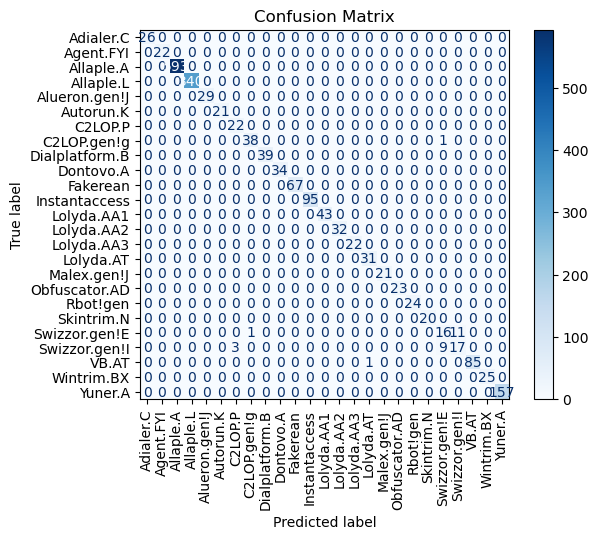

Test Accuracy: 98.61%


In [34]:
evaluate_model(model, test_loader)

In [ ]:
"""
Save the PyTorch model using MLflow for scalale model loading acros environments
"""
import mlflow

model_path= 'model'
with mlflow.start_run():
    mlflow.pytorch.log_model(model, model_path+'/malware_detection_model')
    print(f"Model saved in MLflow under run ID: {mlflow.active_run().info.run_id}")

2024/12/11 23:02:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/11 23:02:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\arun8\AppData\Local\Temp\tmpao41etnk\model\data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2024/12/11 23:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved in MLflow under run ID: b726c4c935364859ae21217744eeefd1


## Visualize predictions

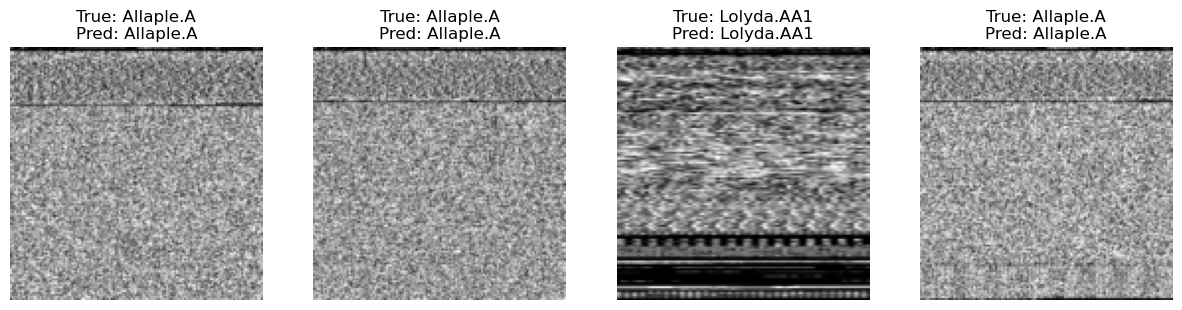

In [7]:
import torch
import matplotlib.pyplot as plt

# Function to visualize test images and their predictions
def visualize_predictions(model, test_loader, num_images=4):
    model.eval()  # Set model to evaluation mode
    
    # Get a few images and labels from the test set
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Move images and labels to the same device as the model (CPU or GPU)
    images, labels = images.to(device), labels.to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

    # Display images and their predicted vs true labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.axis('off')

        # True and predicted labels
        true_label = labels[i].item()
        predicted_label = predicted[i].item()

        true_class = dataset.classes[true_label]
        predicted_class = dataset.classes[predicted_label]

        ax.set_title(f"True: {true_class}\nPred: {predicted_class}")

    plt.show()

# Evaluate and visualize predictions
visualize_predictions(model, test_loader, num_images=4)


## Conclusion 

The predictions for malware is accurate and it does not show signs of overfitting. The model is robust as it is simple and can be scaled for bigger datasets and add value to any teams that use this to find malware in exceutable files.

Note: Please use the first cell mentioned for Exe convertion and alter the paths as required. For the dataset this dataset represents a already converted datatset MalImg dataset used for the project.